# Lumoshive Data Science Final Project

### Basic Configurations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import math
import seaborn as sns
import re

## SKlearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report,precision_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.calibration import LabelEncoder

In [2]:
df_sb = pd.read_csv("subscriptions_mix.csv")
df_sb2 = pd.read_csv("subscriptions_60000.csv")
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)

C:\Users\samsu\AppData\Local\Temp\ipykernel_16896\3886751487.py:1: DtypeWarning: Columns (4,6,10,13,16,18,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sb = pd.read_csv("subscriptions_mix.csv")
C:\Users\samsu\AppData\Local\Temp\ipykernel_16896\3886751487.py:2: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sb2 = pd.read_csv("subscriptions_60000.csv")


In [3]:
df_sb.isna().sum()

id                        0
created_at                0
country                   0
operator                  0
service                   0
source                  604
msisdn                    0
status                    0
cycle                     0
adnet                161443
revenue                   0
subs_date                 0
renewal_date              0
freemium_end_date    108911
unsubs_from          245453
unsubs_date          204626
service_price             0
currency               5721
profile_status        27397
publisher            197964
trxid                188763
pixel                219888
handset              211738
browser              208785
attempt_charging          0
success_billing           0
dtype: int64

In [4]:
df_sb2.isna().sum()

id                       0
created_at               0
country                  0
operator                 0
service                  0
source               10644
msisdn                   0
status                   0
cycle                    1
adnet                26938
revenue                  0
subs_date                0
renewal_date            33
freemium_end_date    35527
unsubs_from          31174
unsubs_date          23198
service_price            0
currency             12744
profile_status       17600
publisher            34339
trxid                23735
pixel                44687
handset              43752
browser              37664
attempt_charging         0
success_billing          0
dtype: int64

### Data Cleaning

#### Concatenate Old & New Sub Table

In [5]:
df_merge = pd.concat([df_sb, df_sb2])

In [6]:
#High percentage of missing value, so we drop these columns
cols_drop = {
    'freemium_end_date',
    'unsubs_from', 
    'publisher',
    'trxid',
    'pixel',
    'handset',
    'browser',
}

df_merge.drop(cols_drop, axis=1, inplace=True)

df_merge.drop(df_merge[df_merge['cycle'].isna()].index, inplace = True)

In [7]:
## Since currency of "Kip" & "LAK" are the same. We will change Kip to Lak
df_merge["currency"] = df_merge["currency"].astype(str).apply(lambda x : "LAK" if x == "Kip" else x)

## Upper and Lowercasing string
df_merge["operator"] = df_merge["operator"].astype(str).apply(lambda x : x.lower())
df_merge["source"] = df_merge["source"].astype(str).apply(lambda x : x.lower())
df_merge["service"] = df_merge["service"].astype(str).apply(lambda x : x.lower())
df_merge["country"] = df_merge["country"].astype(str).apply(lambda x : x.upper())
df_merge["profile_status"] = df_merge["profile_status"].astype(str).apply(lambda x : x.lower())

## Cleaning the adnet by splitting them.
df_merge["adnet"] = df_merge["adnet"].astype(str).apply(lambda x : x.split("-")[0].lower())
df_merge["adnet"] = df_merge["adnet"].replace('nan', np.nan) ## Let nan be NaN numpy
df_merge.dropna(subset=['adnet'], inplace=True)

## Currency Changes
df_merge["currency"] = np.where(df_merge["country"] == "ID", df_merge["currency"].fillna("IDR"), df_merge["currency"])
df_merge["currency"] = np.where(df_merge["country"] == "SN", df_merge["currency"].fillna("XOF"), df_merge["currency"])

## We also do not know which source does "SN" use, therefore we can fill the NaN value to Unknown / Another option that we can use impute.
df_merge['source'].fillna("None", inplace=True)

## There is a wild "2" which we do not know what does it mean, so it is better to drop it

df_merge.drop(df_merge[df_merge['status'] == 2].index, inplace = True)

In [8]:
df_merge['subs_date'] = df_merge['subs_date'].astype(str)
df_merge['subs_date'] = df_merge['subs_date'].str.split().str[0]

df_merge['renewal_date'] = df_merge['renewal_date'].astype(str)
df_merge['renewal_date'] = df_merge['renewal_date'].str.split().str[0]

df_merge['unsubs_date'] = df_merge['unsubs_date'].astype(str)
df_merge['unsubs_date'] = df_merge['unsubs_date'].str.split().str[0]

df_merge['subs_date'] = pd.to_datetime(df_merge['subs_date'], errors= 'coerce')
df_merge['renewal_date'] = pd.to_datetime(df_merge['renewal_date'], errors='coerce')
df_merge['unsubs_date'] = pd.to_datetime(df_merge['unsubs_date'], errors='coerce')


# Duration can be minus, will be thought later
# df_merge["duration"] = (df_merge['unsubs_date'] - df_merge['subs_date']).dt.days

In [9]:
#Invalid Revenue Format will be dropped (only 604 rows)
df_merge[df_merge["revenue"] == "150:00:00"] # 423 Rows
df_merge[df_merge["revenue"] == "0:00"] # 181 Rows

mask = df_merge["revenue"].isin(["150:00:00", "0:00"])
df_merge.drop(df_merge[mask].index, inplace=True)

In [10]:
def convert_revenue(row):
    if row['country'] == 'SN':
        return float(row['revenue']) * 0.0018
    elif row['country'] == 'TH':
        return float(row['revenue']) * 0.032
    elif row['country'] == 'OM':
        return float(row['revenue']) * 22.6
    elif row['country'] == 'LA':
        return float(row['revenue']) * 0.00011
    elif row['country'] == 'ID':
        return float(row['revenue']) * 0.000065
    elif row['country'] == 'PH':
        return float(row['revenue']) * 0.018
  
df_merge['revenue (USD)'] = df_merge.apply(convert_revenue, axis=1)
df_merge['revenue (USD)']

3        0.000
6        0.000
7        0.000
12       0.000
28       0.000
         ...  
56671    0.000
56688    0.384
56699    0.000
56700    0.000
56702    0.000
Name: revenue (USD), Length: 177031, dtype: float64

#### Splitting the Data

In [11]:
# Create a label encoder object
label_encoder = LabelEncoder()

# Apply label encoding to the 'adnet' column
df_merge['adnet_encoded'] = label_encoder.fit_transform(df_merge['adnet'])

## Splitting the data (Using 70/30 split)
X = df_merge[['status', 'adnet_encoded', 'attempt_charging', 'success_billing']]
y = df_merge['revenue (USD)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

#Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (123921, 4) (123921,)
Testing set shape: (53110, 4) (53110,)


### Data Training

#### Data Model / Techniques

##### Linear Regression

RMSE: 52592.24721654467
R^2: 0.2729485624269725


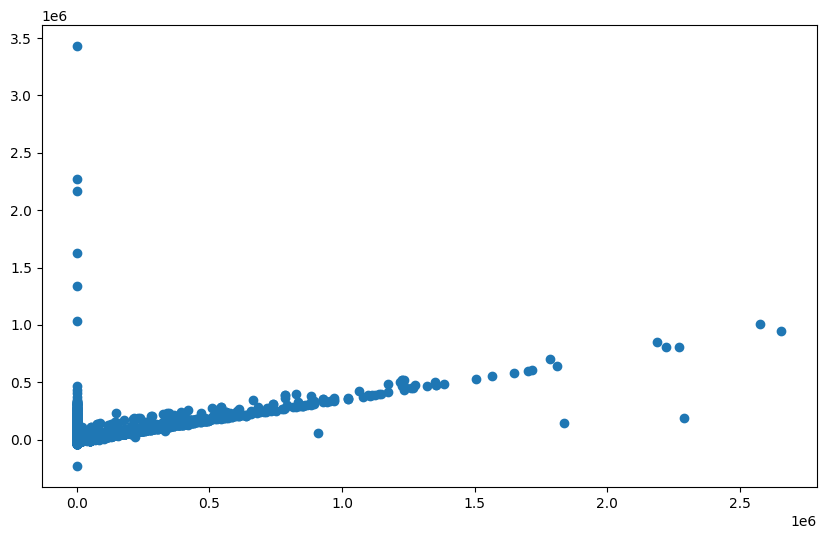

In [12]:
# Create the regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Calculating metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print("RMSE:", rmse)
print("R^2:", r2)

#plot linear regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)

plt.show()


##### Decision Tree

RMSE: 21285.744299699294
R^2: 0.8809034001815601
            feature  importance
3   success_billing    0.443371
1     adnet_encoded    0.407656
2  attempt_charging    0.143682
0            status    0.005291


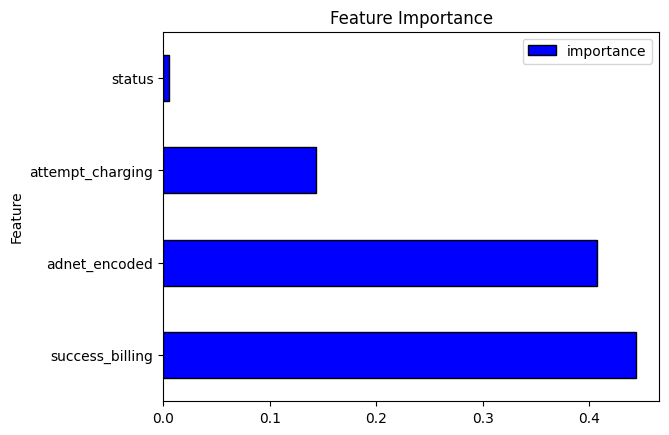

In [13]:
from sklearn.tree import export_graphviz
import graphviz

# Create the Decision Tree Regressor model
dt_regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
# Fit the model to the training data (use the scaled data if you have scaled it)
dt_regressor.fit(X_train_scaled, y_train)

y_pred_dt = dt_regressor.predict(X_test_scaled)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
r2_dt = r2_score(y_test, y_pred_dt)

print("RMSE:", rmse_dt)
print("R^2:", r2_dt)

# Print which features are the most important and their importance values
feature_importances = dt_regressor.feature_importances_
feature_names = X.columns.tolist()
feature_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances}).sort_values('importance', ascending=False)
print(feature_df)

feature_names = X.columns.tolist()

# Export the decision tree to a dot file
dot_data = export_graphviz(dt_regressor, out_file=None, 
                           feature_names=feature_names,
                           filled=True, rounded=True, 
                           special_characters=True)

# Generate the graph from the dot file
graph = graphviz.Source(dot_data)

# Save and display the graph
graph.render("decision_tree")

# Feature importance horizantal bar plot
feature_df.plot(x='feature', y='importance', kind='barh', color='blue', edgecolor='black', )
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.show()

##### Ridge Regression

RMSE: 52592.18822457198
R^2: 0.27295019347248817


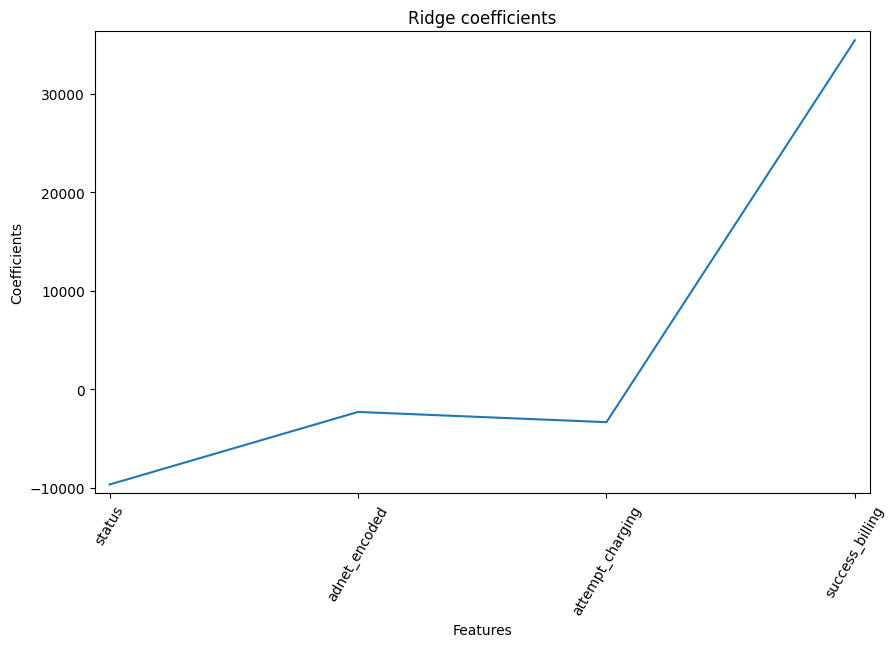

In [14]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# Initialize Ridge Regression model with an alpha value
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_reg.predict(X_test_scaled)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("RMSE:", rmse_ridge)
print("R^2:", r2_ridge)

#visualize the coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(len(X.columns)), ridge_reg.coef_)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients')
plt.margins(0.02)
plt.show()

##### Lasso Regression

RMSE: 52592.21976353261
R^2: 0.27294932146457695


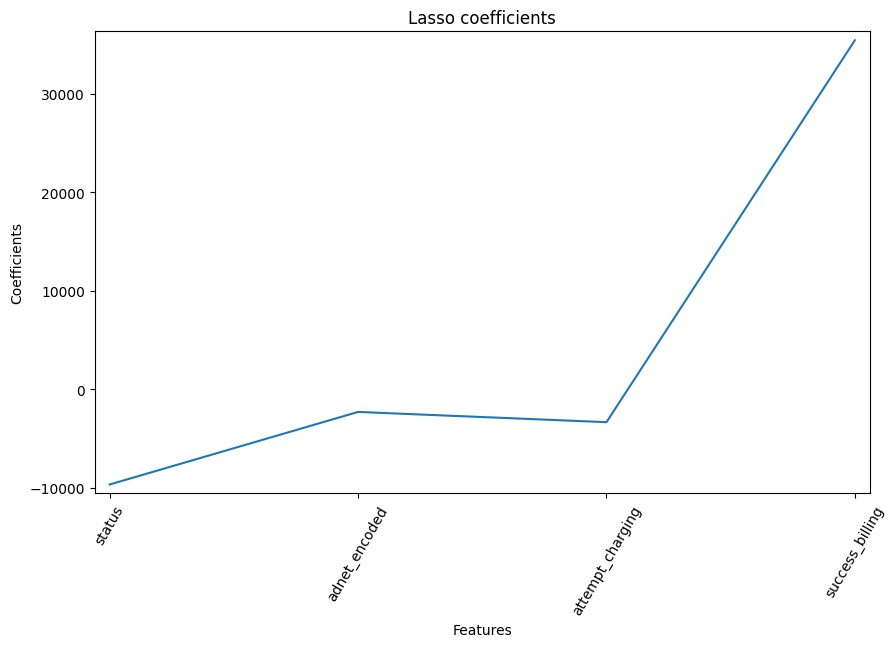

In [15]:
# Create the Lasso Regression model
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)

y_pred_lasso = lasso_reg.predict(X_test_scaled)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("RMSE:", rmse_lasso)
print("R^2:", r2_lasso)

#visualize the coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(len(X.columns)), lasso_reg.coef_)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients')
plt.margins(0.02)
plt.show()



##### Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

#RFR uses features names

regressor =  RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print(y_pred.shape)

rmse = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE: ", rmse)
print("R2", r2)
# print("Regressor Score", regressor.score(X_train_scaled, y_train))

# # Feature importance
# feature_importance = regressor.feature_importances_
# print("Feature importance:\n", feature_importance)

# # Print which features are the most important and their importance values
# feature_importance_df = pd.DataFrame({"feature": feature_names, "importance": feature_importance}).sort_values("importance", ascending=True)
# feature_importance_df

# # Feature importance bar plot
# feature_importance_df.plot(x="feature", y="importance", kind="barh", color="red", edgecolor="black")
# plt.title("Feature Importance")
# plt.ylabel("Feature")
# plt.show()



# single_tree = regressor.estimators_[0]

# dot_data = export_graphviz(single_tree, out_file=None, 
#                            feature_names=feature_names,  # Make sure to provide the correct feature names
#                            filled=True, rounded=True, 
#                            special_characters=True)

# # Draw graph
# graph = graphviz.Source(dot_data)

# # Save and display the graph
# graph.render("single_tree")
# graph

(53110,)
RMSE:  14744.538661244549
R2 0.2729485624269725


##### SVR (Support Vector Regression)

In [17]:
# from sklearn.svm import SVR

# svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# svr.fit(X_train_scaled, y_train)

# y_pred = svr.predict(X_test)

# mse = mean_squared_error(y_test, y_pred, squared=False)
# r2 = r2_score(y_test, y_pred)

# print("Mean Squared Error: ", mse)
# print("R-squared (R2) Score: ", r2)


##### K-Neighbors Regressor

In [18]:
from sklearn.neighbors import KNeighborsRegressor


knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print("Mean Squared Error: ", mse)
print("R-squared (R2) Score: ", r2)

Mean Absolute Error: 1277.93820283939
Mean Squared Error:  19631.678967880987
R-squared (R2) Score:  0.8986936733604108


Mean Absolute Error: 12070.472003956102
Mean Squared Error:  1679866096.755177
R-squared (R2) Score:  0.5584332675433692


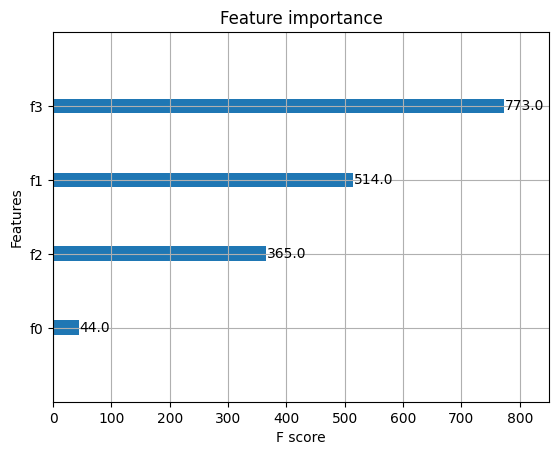

In [19]:
#XGBoost Regressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# give the code below command to understand better
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

xg_reg.fit(X_train_scaled,y_train)

y_pred = xg_reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

print("Mean Squared Error: ", mse)
print("R-squared (R2) Score: ", r2)


# visualize the feature importance
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()



ADABoost


### Data Visualization

##### Non-Merged Data

C:\Users\samsu\AppData\Local\Temp\ipykernel_16896\985815318.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sb, x='country', palette='hsv', order=df_sb['country'].value_counts().index)


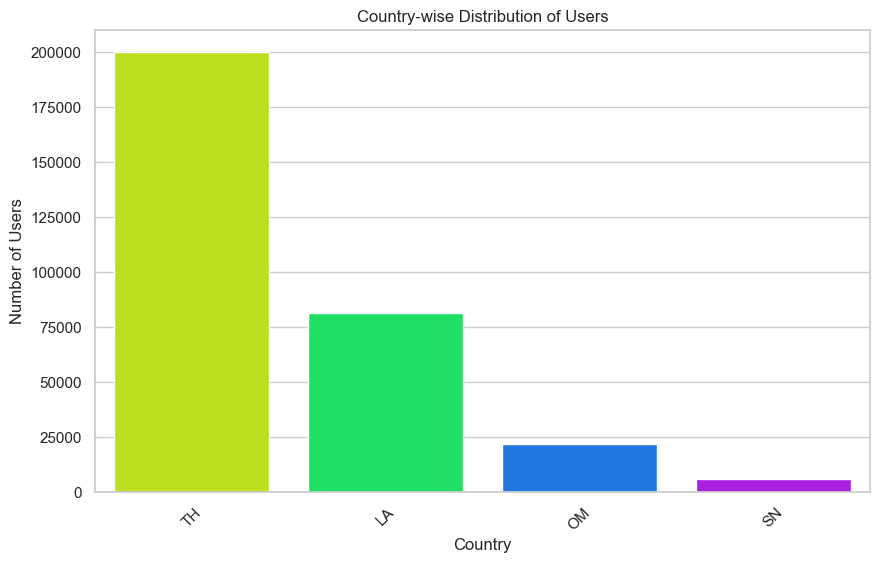

In [20]:
# Setting the visualization style
sns.set(style="whitegrid")

# Country-wise Distribution Visualization using cleaned subscriptions data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='country', palette='hsv', order=df_sb['country'].value_counts().index)
plt.title('Country-wise Distribution of Users')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


C:\Users\samsu\AppData\Local\Temp\ipykernel_16896\1525026309.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sb, x='operator', palette='hsv', order=df_sb['operator'].value_counts().index)


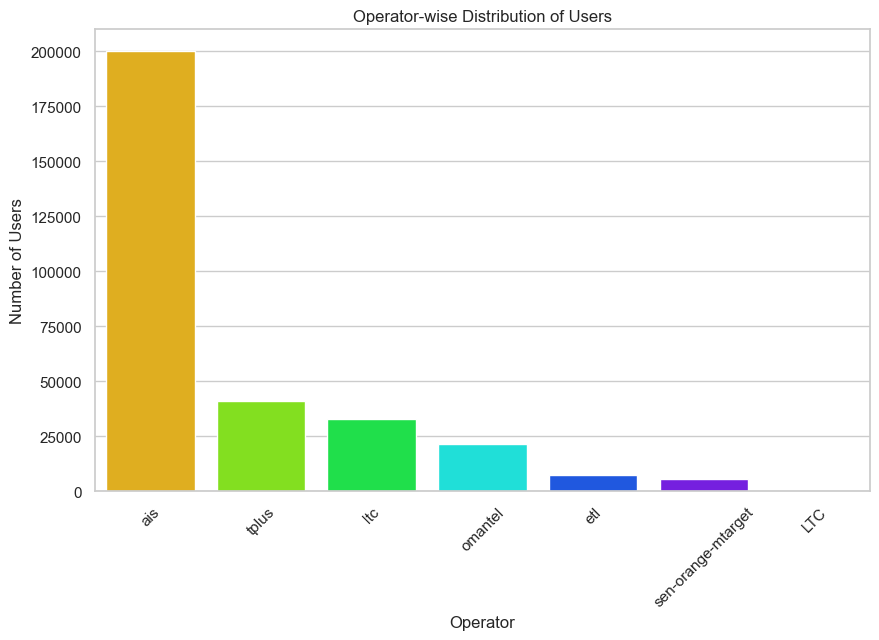

In [21]:
# Operator-wise Distribution Visualization using cleaned subscriptions data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='operator', palette='hsv', order=df_sb['operator'].value_counts().index)
plt.title('Operator-wise Distribution of Users')
plt.xlabel('Operator')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


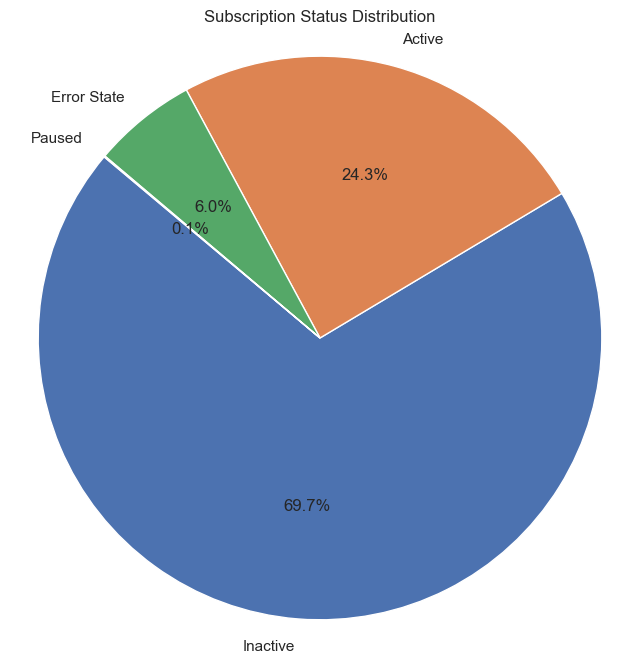

In [22]:

status_meanings = {
    -1: 'Error State',
    0: 'Inactive',  
    1: 'Active',    
    2: 'Paused'  
}

# Map the status codes to meanings
df_sb['status_label'] = df_sb['status'].map(status_meanings)

# Subscription Status Visualization: Pie Chart
status_counts = df_sb['status_label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Subscription Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


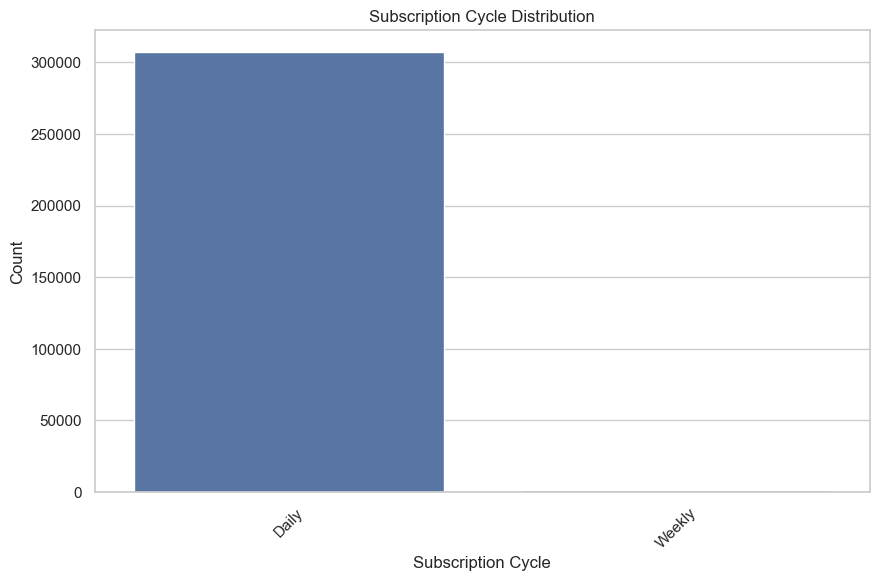

In [23]:
cycle_meanings = {
    'daily': 'Daily',
    'weekly': 'Weekly',
    'monthly': 'Monthly',
    # ... add other cycles as necessary
}

# Map the cycle codes to meanings
df_sb['cycle_label'] = df_sb['cycle'].map(cycle_meanings)

# Subscription Cycle Visualization: Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='cycle_label', order=df_sb['cycle_label'].value_counts().index)
plt.title('Subscription Cycle Distribution')
plt.xlabel('Subscription Cycle')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [24]:
df_sb

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,freemium_end_date,unsubs_from,unsubs_date,service_price,currency,profile_status,publisher,trxid,pixel,handset,browser,attempt_charging,success_billing,status_label,cycle_label
0,302164,2023-09-13 09:47:57.713,TH,ais,459505104,sms,66988602911,0,daily,NaN,0,2022-10-20 19:28:02.000,2023-09-14 00:00:00.000,2022-10-20 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070749401088.0,NaN,NaN,NaN,15,0,Inactive,Daily
1,3521,2023-09-13 09:21:13.679,TH,ais,459505104,sms,66822243080,0,daily,NaN,0,2020-08-23 16:11:02.000,2023-09-14 00:00:00.000,2020-08-23 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070724300800.0,NaN,NaN,NaN,15,0,Inactive,Daily
2,1,2023-09-13 09:20:20.727,TH,ais,459505106,ivr,666131,0,1,NaN,6,2023-08-25 14:02:05.000,2023-08-26 00:00:00.000,2023-08-25 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230825140205699072.0,NaN,NaN,NaN,1,1,Inactive,NaN
3,4999335,2023-09-13 14:00:22.171,TH,ais,459505105,wap,66650020857,0,daily,star,0,2023-09-09 13:03:24.000,2023-09-14 00:00:00.000,2023-09-09 00:00:00.000,NaN,NaN,6,BATH,Active,star,20230913071052099584.0,star-APP1694223212644066,NaN,NaN,5,0,Inactive,Daily
4,273196,2023-09-13 09:45:33.449,TH,ais,459505104,sms,66635959286,0,daily,NaN,0,2022-09-26 19:36:03.000,2023-09-14 00:00:00.000,2022-09-26 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070115598336.0,NaN,NaN,NaN,15,0,Inactive,Daily
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,kee,0,2023-05-11 09:50:11.000,2023-05-11 09:50:26.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0,Inactive,Daily
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,kee,0,2023-05-11 09:49:50.000,2023-05-11 09:50:09.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0,Inactive,Daily
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11 06:15:24.000,2023-05-11 06:15:52.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0,Inactive,Daily
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11 16:44:57.000,2023-05-11 16:45:19.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0,Inactive,Daily


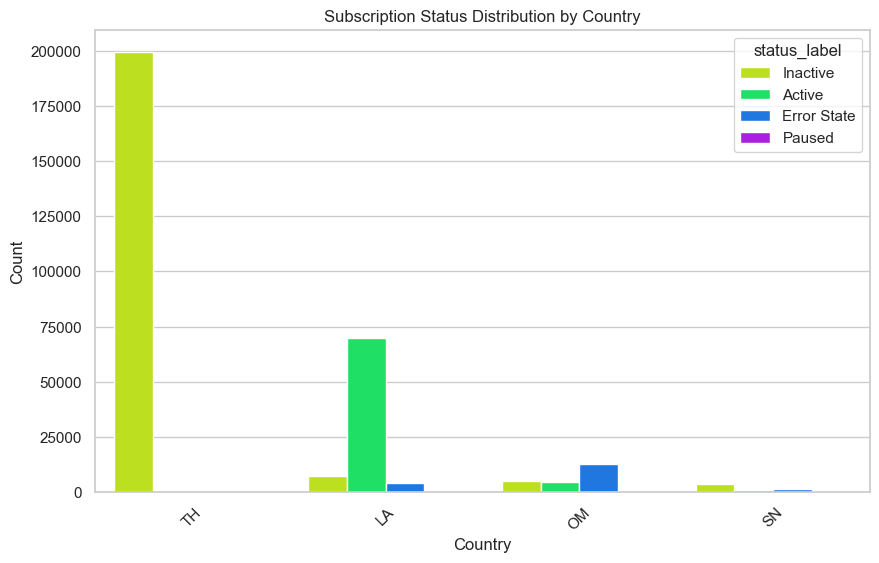

In [25]:
# Subscription Status Distribution by Country
df_sb.groupby(['country', 'operator', 'status_label']).size().reset_index(name='counts')

# Subscription Status Distribution by Country
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='country', hue='status_label', palette='hsv', order=df_sb['country'].value_counts().index)
plt.title('Subscription Status Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

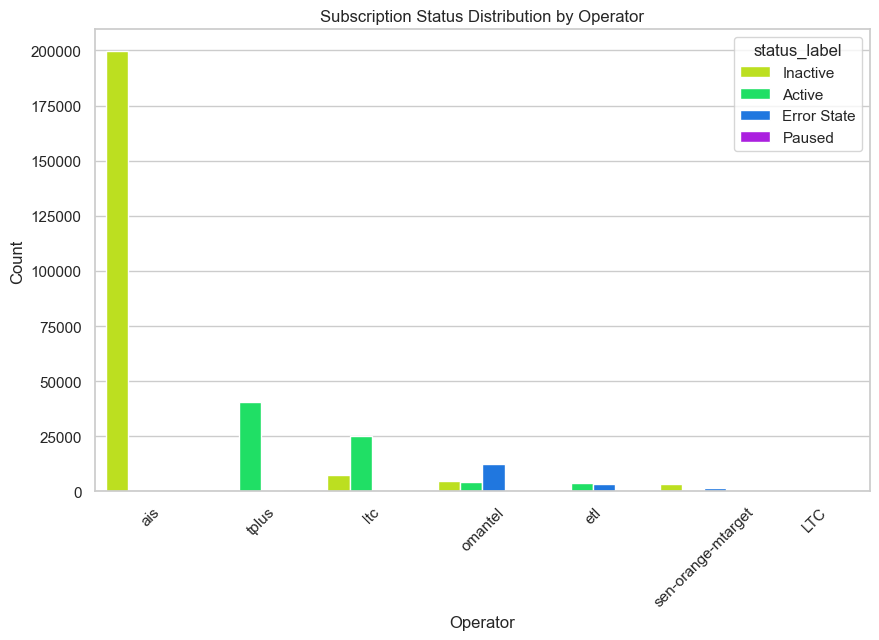

In [26]:

# Subscription Status Distribution by Operator
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='operator', hue='status_label', palette='hsv', order=df_sb['operator'].value_counts().index)
plt.title('Subscription Status Distribution by Operator')
plt.xlabel('Operator')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


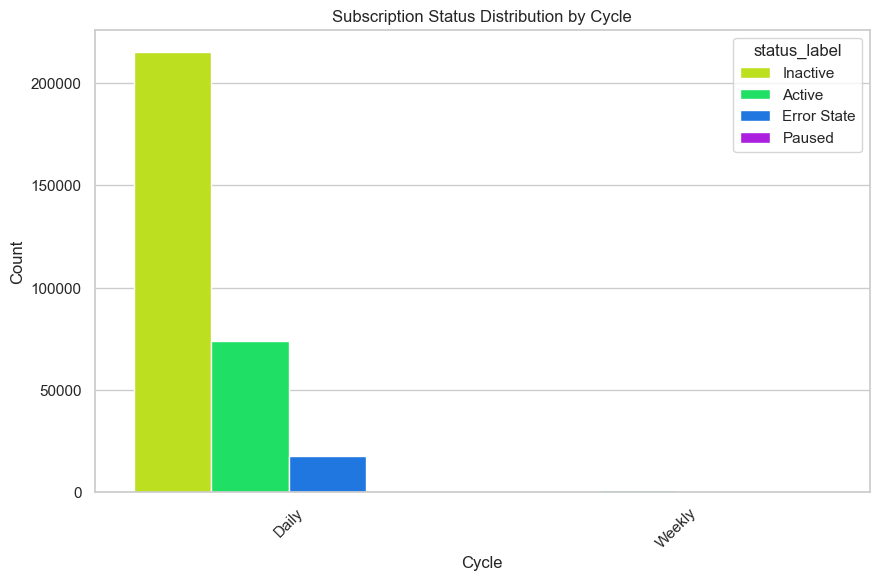

In [27]:
# Subscription Status Distribution by Cycle
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='cycle_label', hue='status_label', palette='hsv', order=df_sb['cycle_label'].value_counts().index)
plt.title('Subscription Status Distribution by Cycle')
plt.xlabel('Cycle')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


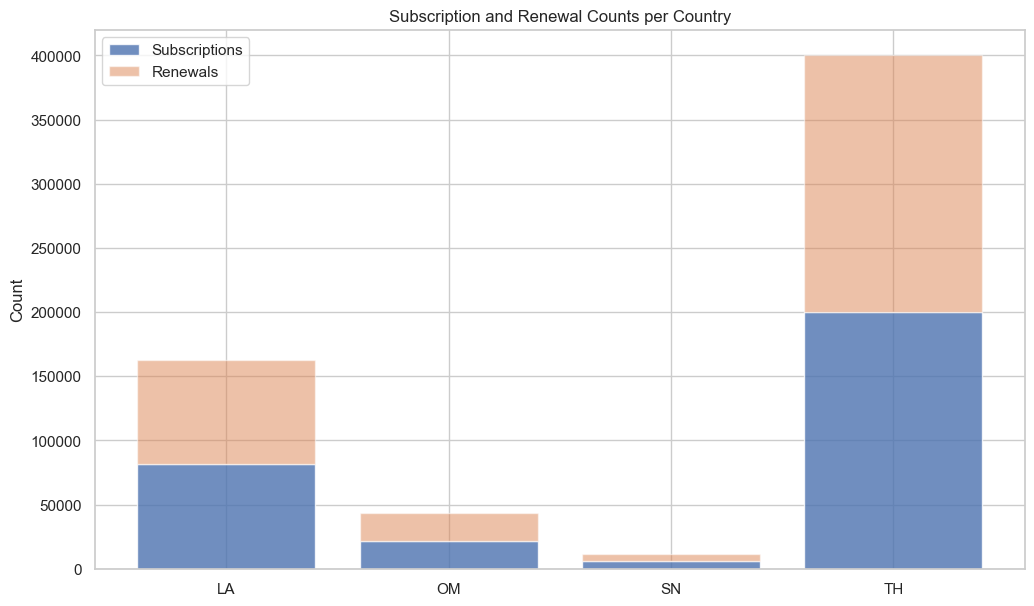

In [28]:
subscriptions_count = df_sb.groupby('country').size().reset_index(name='Subscription_Count')
renewals_count = df_sb.groupby('country').size().reset_index(name='Renewal_Count')
subs_renewals_per_country = pd.merge(subscriptions_count, renewals_count, on='country', how='outer').fillna(0)
plt.figure(figsize=(12, 7))
countries = subs_renewals_per_country['country']
subscription_counts = subs_renewals_per_country['Subscription_Count']
renewal_counts = subs_renewals_per_country['Renewal_Count']

plt.bar(countries, subscription_counts, align='center', alpha=0.8, label='Subscriptions')
plt.bar(countries, renewal_counts, align='center', alpha=0.5, label='Renewals', bottom=subscription_counts)

# plt.xticks(y_pos, countries)
plt.ylabel('Count')
plt.title('Subscription and Renewal Counts per Country')
plt.legend()

plt.show()



In [29]:
# df_sb['subs_date'].max()

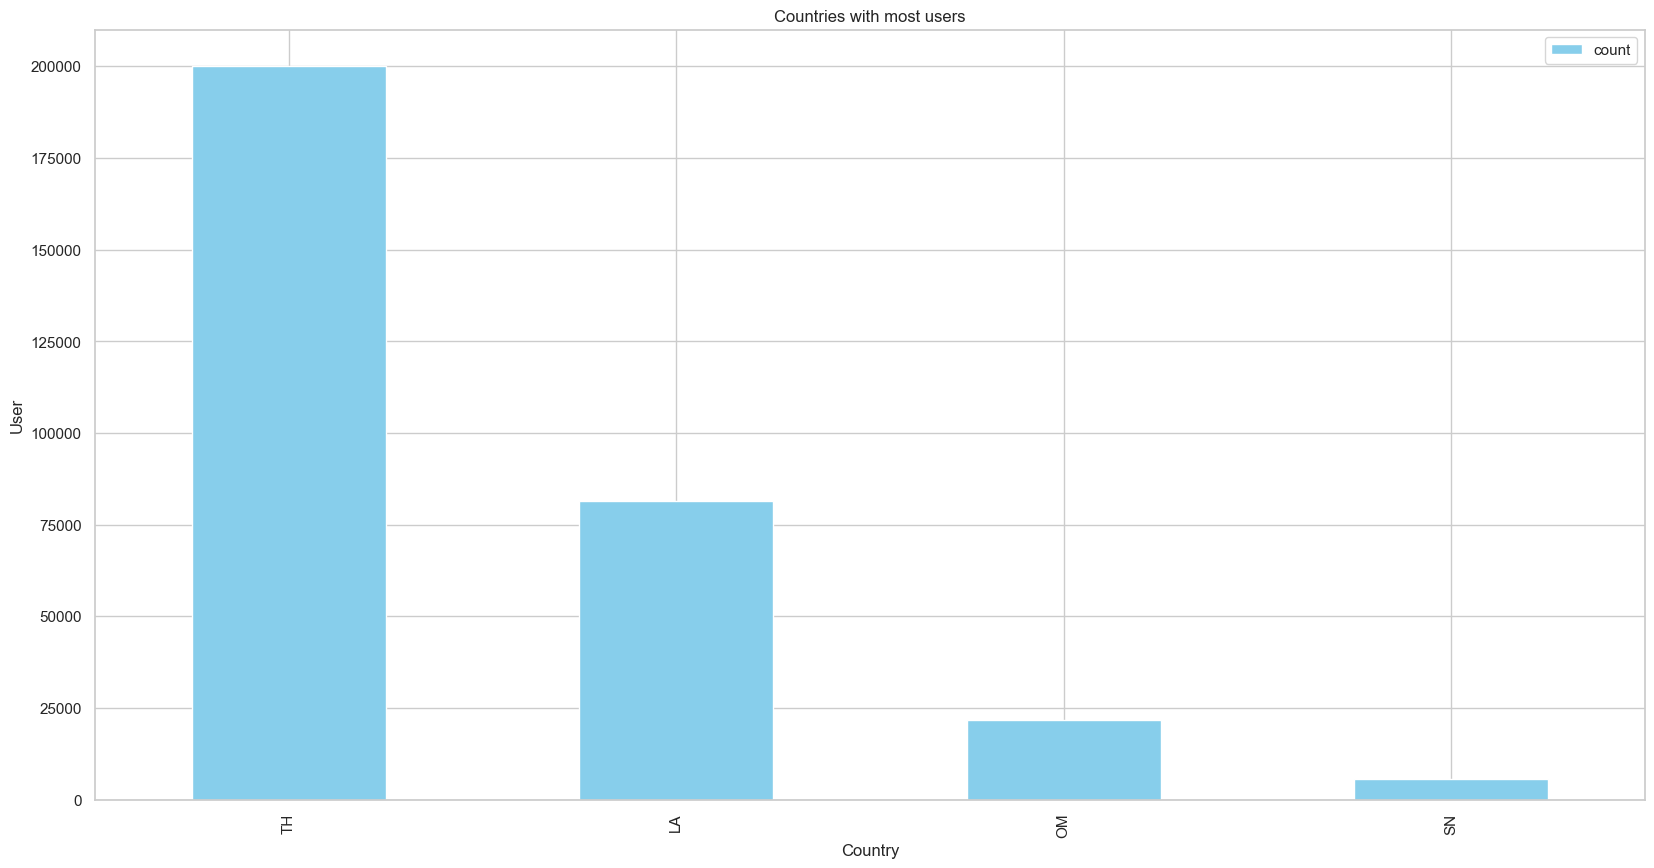

In [30]:
countries = df_sb['country'].value_counts()
topCountries = countries.head(20)
fig = plt.subplots(figsize=(20, 10))

topCountries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('User')
plt.title('Countries with most users')
plt.legend()
plt.show()



C:\Users\samsu\AppData\Local\Temp\ipykernel_16896\3810454579.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sb, x='adnet', palette='hsv', order=df_sb['adnet'].value_counts().index)


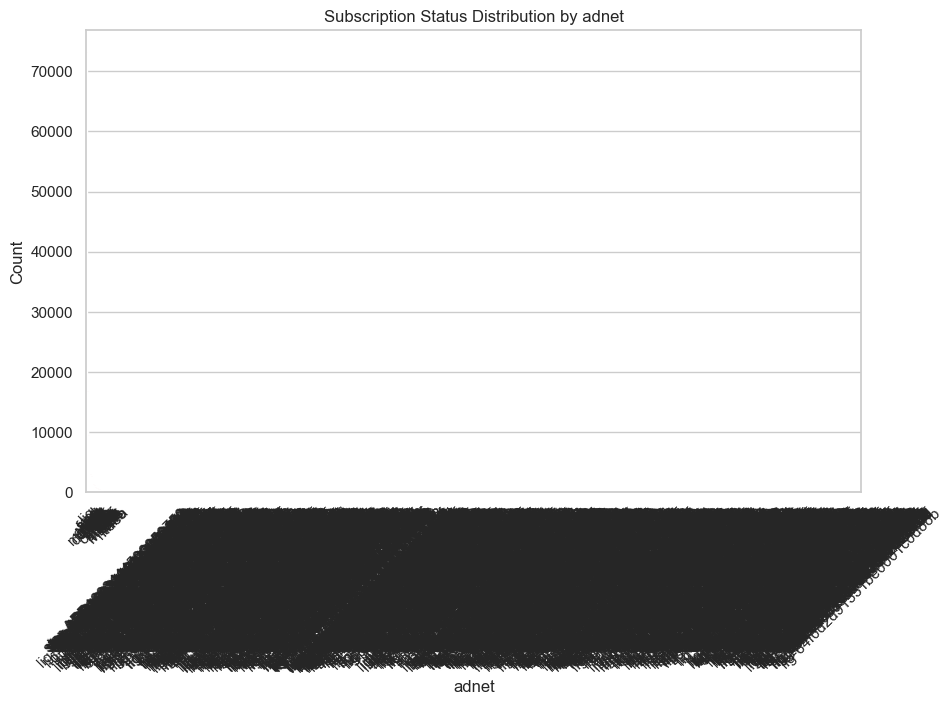

In [31]:

# revenue based on adnet
df_sb.groupby(['adnet']).size().reset_index(name='counts')

# revenue based on adnet 
#exclude nan
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='adnet', palette='hsv', order=df_sb['adnet'].value_counts().index)
plt.title('Subscription Status Distribution by adnet')
plt.xlabel('adnet')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Renewal, Retry, Notif, Unsubscribe, First_charge, 


In [32]:
cycle_cnt = df_tr['cycle'].value_counts()
cycle_cnt.plot(kind='bar',color='skyblue')
plt.show()

## Keep this

NameError: name 'df_tr' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

#Country
sns.countplot(data=df_sb, x='country', ax=axes[0], order=df_sb['country'].value_counts().index)
axes[0].set_title('Distribution of Subscriptions by Country')
axes[0].set_ylabel('Number of Subscriptions')
axes[0].tick_params(axis='x', rotation=45)

#Service
sns.countplot(data=df_sb, x='service', ax=axes[1], order=df_sb['service'].value_counts().index)
axes[1].set_title('Distribution of Subscriptions by Service')
axes[1].set_ylabel('Number of Subscriptions')
axes[1].tick_params(axis='x', rotation=45)

#Operator
sns.countplot(data=df_sb, x='operator', ax=axes[2], order=df_sb['operator'].value_counts().index)
axes[2].set_title('Distribution of Subscriptions by Operator')
axes[2].set_ylabel('Number of Subscriptions')
axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## Keep this

In [ ]:
df_sb